<center>

*******************************************************************************************
<font size="4">
Son &nbsp; &nbsp; <br>
Synchronisation of Swaying Motion<br>
<font size="3">
Search for Optimal Parameters<br>
</font>

##### 8 August 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* Measurement of the synchronisation of musicians intermittently swaying to the beat of the music. The raw data is a performance of five musicians standing up, recorded in video. The musicians swayed intermittently, depending on how busy they were playing or singing. The number of musicians swaying was annotated in sections. A section starts when the number of musicians swaying changes. Also, the average frequency of the say was obtained by manually tapping, and found to be 0.28 Hz. The position of the neck of each musician was extracted from the video, resulting in five time-series. The group synchronisation of the time-series was quantified with several techniques. The correspondence of synhcronisation and number of annotated musicians swaying, is assessed by rank correlation.
>
* This program performs a grid-search for parameters yielding the highest synchronisation, using the following measures:
    *  Kuramoto order parameter *r* (Strogatz, 2000): Phase coherence (how close in phase the oscillators are).
    *  *Rho* statistic (Richardson et al., 2012): A statistical version of Kuramoto's *r*.
    *  Phase-Locking Values (*PLV*) (Mormann et al., 2000): Stability of phase difference, in time.
    *  Generalised Cross-Wavelet Transform (*GXWT*) (Toiviainen & Hartmann, 2022): Amplitude and absolute-valued phase coherence (when the phase difference is pi radians, it is considered in-phase).
>
* Data:
    * Video: https://osf.io/gnybc
        * Reference:\
            Clayton, M., Tarsitani, S., Jankowsky, R., Jure, L., Leante, L., Polak, R., ... & Jakubowski, K. (2021). The interpersonal entrainment in music performance data collection. *Empirical Musicology Review, 16*(1), 65-84.
    * Tracked pose raw and preprocessed: https://osf.io/3nfs9
>
* Instructions:

    Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [ ]:
import sys
import csv
import itertools
from os import path
from time import time
from datetime import timedelta

import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
from IPython.display import display, HTML

sc_path = 'C:/Users/me/SynCoord/src' # <--- SynCoord's source folder
sys.path.append(sc_path)
import syncoord as sc

matlab_connected = False

***
### Declare paths and parameters

In [2]:
extfunc_path = 'C:/MyTemp/Matlab'  # <--- folder with external Matlab functions
gxwt_path = sc_path                # <--- folder with gxwt Matlab function

main_path = 'C:/Users/me'
project_folder = main_path + '/Son'                    # <--- project folder

annot_ffn = project_folder + '/Son_annot_sc.csv'       # <--- annotations file (e.g., ID, Sections)

pose_tracking_path = project_folder + '/pose_tracking'
prep_folder = pose_tracking_path + '/preprocessed'     # <--- preprocessed data folder (parquet files)

results_folder = project_folder + '/results'           # <--- results' folder

data_fps = 25 # <--- sampling frequency of video
n_dim = 2     # <--- number of data dimensions
sway_f = 0.28 # <--- swaying frequency (Hz)

***
## Load and visualise data

>
#### Position
One point of the body (neck) for each musician.

In [3]:
data_1 = sc.ptdata.load( prep_folder, {'fps':data_fps,'ndim':2},
                         annot_path=annot_ffn, print_info=True )

index; key; Name; duration (s):
  0; 0; Son; 5:58.600


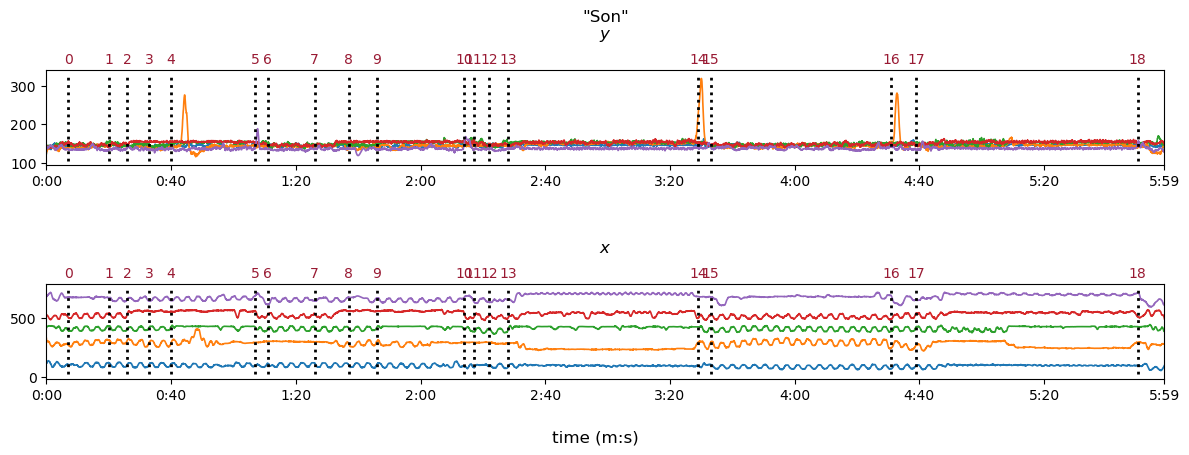

In [4]:
data_1.visualise()

>
#### Number of swaying points
Manually annotated for each section.

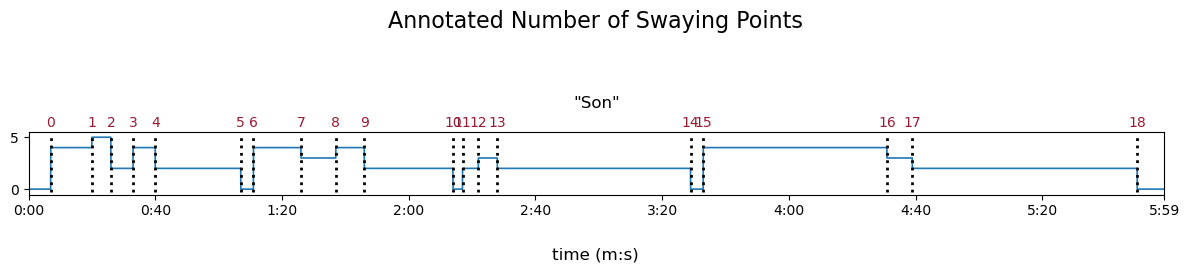

In [5]:
n_frames = data_1.data[0].shape[-1]
sec_f = data_1.topinfo.trimmed_sections_frames[0]+[n_frames]
n_sway = [int(v) for v in data_1.topinfo.n_swaying[0].split(',')]
n_sway_cont = np.zeros(n_frames)
i_prev = 0
for i_next,ns in zip(sec_f,n_sway):
    n_sway_cont[i_prev:i_next] = ns
    i_prev = i_next
nsc_ptd = data_1.copy()
nsc_ptd.data[0] = n_sway_cont
nsc_ptd.visualise(figtitle='Annotated Number of Swaying Points')

***
## Functions' definitions

#### Utility

In [6]:
def evstr(a):
    if isinstance(a,str) and (a != 'none'): a = eval(a)
    return a

>
#### Low-pass filter

In [7]:
def get_lpf( d_1, window_size ):

    if window_size:
        window_size = evstr(window_size)
        d_2 = sc.ptdata.smooth( d_1, filter_type='savgol', window_size=window_size, order=1 )
    else: d_2 = d_1
    return d_2


>
#### Reduction to one dimension per point

In [8]:
def get_red1D( d_2, red1D_method ):

    if red1D_method == 'speed':
        d_3 = sc.ptdata.apply( d_2, sc.ndarr.tder, dim=2 )
    elif red1D_method == 'norms':
        n1 = sc.ptdata.norm( d_2, order=1, axis=-2 )
        n2 = sc.ptdata.norm( d_2, order=2, axis=-2 )
        d_3 = sc.ptdata.apply2( n1, n2, np.add )
    elif (red1D_method is not None) and (red1D_method in 'xy'):
        d_3 = sc.ptdata.select( d_2, axis='yx'.index(red1D_method) )
    else:
        d_3 = d_2
    return d_3


>
#### Phase

In [9]:
def get_phase( d_4, method, pk_min_dist, fft_freq, fps ):

    pk_min_dist = evstr(pk_min_dist)
    fft_freq = evstr(fft_freq)
    if method == 'peaks':
        phi = sc.ptdata.peaks_to_phase( d_4, fps=fps, min_dist=pk_min_dist,
                                          endstart=True, height=0.2, prominence=0.1 )
    elif method == 'FFT':
        fft_win_s = 1/fft_freq
        phi = sc.ptdata.fourier( d_4, fft_win_s, output='phase', mode='same' )
        phi = sc.ptdata.select( phi, frequency=0 )
    return phi


>
#### Synchronisation

In [10]:
def get_gsync( d_5, method, plv_window, gxwt_freq, fps, mat_eng ):

    plv_window = evstr(plv_window)
    gxwt_freq = evstr(gxwt_freq)
    if method == 'r':
        sync_1 = sc.ptdata.kuramoto_r( d_5 )
    elif method == 'Rho':
        sync_1 = sc.ptdata.rho( d_5 )
    elif method == 'PLV':
        plv_pairwise = sc.ptdata.winplv( d_5, plv_window )
        plv_margin = round(plv_window*data_fps)
        plv_pairwise = sc.ptdata.apply( plv_pairwise, sc.utils.nanbordz, margin=plv_margin )
        sync_1 = sc.ptdata.aggrax( plv_pairwise, function='mean' )
    elif method == 'GXWT':
        minmaxf = [gxwt_freq-0.01,gxwt_freq+0.01] # minimum and maximum frequencies for GXWT (Hz)
        if d_5.data[0].ndim == 3: fixed_axes = [-2,-1]
        elif d_5.data[0].ndim == 2: fixed_axes = -1
        xws_pairwise = sc.ptdata.gxwt( d_5, minmaxf, 0, fixed_axes, matlabeng=mat_eng  )
        sync_1 = sc.ptdata.aggrax( xws_pairwise, axis=0, function='mean' )
    try:
        if sync_1.names.dim[-2] == 'frequency':
            sync_2 = sc.ptdata.aggrax( sync_1, axis=-2, function='mean' )
        else: sync_2 = sync_1
    except: sync_2 = sync_1

    return sync_2


>
#### Rank correlation between sections' continuous synchronisation and annotated number of musicians swaying

In [11]:
def get_cont_corr( sync_2, nsc ):

    for nan_margin,v in enumerate(sync_2.data[0]):
        if not np.isnan(v): break
    d_margin = nan_margin * 2
    sync_2_d_valid = sync_2.data[0][slice(d_margin,len(sync_2.data[0])-d_margin-1)]
    nsc_d_valid = nsc[slice(d_margin,len(nsc)-d_margin-1)]
    if len(sync_2_d_valid) < len(nsc_d_valid): nsc_d_valid = nsc_d_valid[:-1]
    tau_c, p_c = stats.kendalltau(sync_2_d_valid, nsc_d_valid)
    return tau_c, p_c


>
#### Rank correlation between sections' mean synchronisation and annotated number of musicians swaying

In [12]:
def get_means_corr( sync_2, n_sw ):

    sync_secmeans = sc.ptdata.secstats( sync_2, statnames='mean', last=True, omitnan=True )
    sync_secmeans_rs = sync_secmeans.data[0] - min(sync_secmeans.data[0])
    sync_secmeans_rs = sync_secmeans_rs / max(sync_secmeans_rs)
    n_sw_rs = [v/max(n_sw) for v in n_sw]
    tau_m, p_m = stats.kendalltau(sync_secmeans_rs, n_sw_rs)
    return tau_m, p_m


***
## Optimal parameters for maximum synchronisation

>
### Parameters and values

In [13]:
sync_methods = ['r', 'Rho', 'PLV', 'GXWT']                 # methods to quantify synchronisation

# Common to all methods:
LPF_windows = [ '1/(5*sway_f)', '1/(4*sway_f)',            # Savitzy-Golay filter window length (s)
                '1/(3*sway_f)', '1/(2*sway_f)',
                '1/sway_f', '3/(2*sway_f)' ]
transf_freqs = ['sway_f/2', 'sway_f', '2*sway_f']          # frequency of FFT or XWT (Hz)

# Only r, Rho, and PLV:
dimred_methods_1D = ['norms', 'speed', 'x', 'y']           # reduction to 1 dimension
phase_methods = ['peaks', 'FFT']                           # phase extraction method
peaks_min_dist = ['sway_f/4', 'sway_f/2', 'sway_f']        # mininmum distance between peaks

# Only PLV:
plv_windows = LPF_windows + ['2/sway_f', '3/sway_f']       # PLV window length (s)

# Only GXWT:
dimred_methods_GWXT = ['none', 'norms', 'speed', 'x', 'y'] # reduction to 1 dimension


>
### Synchronisation for all combinations

In [14]:
verbose = False # <--- print last result while results are produced

headers = [ 'i','tau cont','p cont','tau means','p means','sync method',
            'LPF 1 window','dimred method', 'LPF 2 window','phase method',
            'peaks min dist','transf freq','PLV window' ]
all_results = {k:[] for k in headers}
all_results_ffn = results_folder + '/all_results.csv'
start_time = time()
if path.isfile(all_results_ffn):
    with open(all_results_ffn,'r',newline='') as f:
        csv_reader = csv.reader(f)
        next(csv_reader, None)  # skip headers
        for i_row,v_row in enumerate(csv_reader):
            for k, v_cell in zip(headers,v_row):
                try:
                    if k == 'i': v_cell = int(v_cell)
                    else: v_cell = float(v_cell)
                except: pass
                all_results[k].append(v_cell)
        i_start = i_row
        compute = False
else:
    compute = True
    i_start = 0
i_comb = 0
with open(all_results_ffn,'a',newline='') as f:
    writer = csv.writer(f)
    if i_start == 0: writer.writerow([s for s in headers]) # CSV headers
    for sm in sync_methods:
        sgrid = {'LPF_1_win':LPF_windows}
        if sm == 'GXWT':
            sgrid['dimred_method'] = dimred_methods_GWXT
            sgrid['LPF_2_win'] = LPF_windows
            sgrid['phase_method'] = ['none']
            sgrid['pk_min_dist'] = ['none']
            if compute and not matlab_connected: # run multiple times without reconnecting to Matlab
                m_eng = sc.utils.matlab_eng([extfunc_path,gxwt_path])
                matlab_connected = True
        else: # r, Rho, PlV
            sgrid['dimred_method'] = dimred_methods_1D
            sgrid['LPF_2_win'] = LPF_windows
            sgrid['phase_method'] = phase_methods
            m_eng = None
        for v in itertools.product(*sgrid.values()):
            iter_param = {'sync_method':sm, **dict(zip(sgrid.keys(), v))}
            if compute:
                data_2 = get_lpf( data_1, iter_param['LPF_1_win'] )
                data_3 = get_red1D( data_2, iter_param['dimred_method'] )
                data_4 = get_lpf( data_3, iter_param['LPF_2_win'] )
            if iter_param['phase_method'] == 'peaks': phase_param = peaks_min_dist
            elif iter_param['phase_method'] == 'FFT': phase_param = transf_freqs
            elif iter_param['phase_method'] == 'none': phase_param = [None] # GXWT
            if sm == 'PLV': gs_param = plv_windows
            elif sm == 'GXWT': gs_param = transf_freqs
            else: gs_param = [None]
            for php_v in phase_param:
                if compute:
                    if php_v:
                        if iter_param['phase_method'] == 'peaks':
                            pk_md = php_v
                            transf_f = 'none'
                        elif iter_param['phase_method'] == 'FFT':
                            pk_md = 'none'
                            transf_f = php_v
                        data_5 = get_phase( data_4, iter_param['phase_method'],
                                            pk_md, transf_f, data_fps )
                    else:
                        pk_md = 'none'
                        transf_f = 'none'
                        data_5 = data_4
                for gs_v in gs_param:
                    if compute:
                        if sm == 'PLV':
                            plv_w = gs_v
                        elif sm == 'GXWT':
                            plv_w = 'none'
                            transf_f = gs_v
                        else:
                            plv_w = 'none'
                            transf_f = 'none'
                        gsync = get_gsync( data_5, sm, plv_w, transf_f, data_fps, m_eng )
                        tau_c, p_c = get_cont_corr( gsync, n_sway_cont )
                        tau_m, p_m = get_means_corr( gsync, n_sway )
                        all_results['i'].append(i_comb)
                        all_results['tau cont'].append(tau_c)
                        all_results['p cont'].append(p_c)
                        all_results['tau means'].append(tau_m)
                        all_results['p means'].append(p_m)
                        all_results['sync method'].append(sm)
                        all_results['LPF 1 window'].append(iter_param['LPF_1_win'])
                        all_results['dimred method'].append(iter_param['dimred_method'])
                        all_results['LPF 2 window'].append(iter_param['LPF_2_win'])
                        all_results['phase method'].append(iter_param['phase_method'])
                        all_results['peaks min dist'].append(pk_md)
                        all_results['transf freq'].append(transf_f)
                        all_results['PLV window'].append(plv_w)
                        iter_result = [ all_results[k][-1] for k in headers ]
                        writer.writerow(iter_result)
                        if verbose:
                            iter_result_fmt = [ v if isinstance(v,str)
                                                else f'{v:,.3f}' for v in iter_result[1:] ]
                            print(', '.join([str(i_comb)] + iter_result_fmt))
                    else:
                        compute = i_comb == i_start
                    i_comb += 1

    toc = time() - start_time
    toc_fmt = timedelta(seconds=toc)
    print('\ncomputation time = ',str(toc_fmt)[:-3])

all_results_t = pd.DataFrame(all_results).set_index('i')
print(f'\nTotal number of results = {all_results_t.shape[0]}\n')


C:\Users/juigmend/local_documents/SynCoord/src\syncoord\ptdata.py:1074: RuntimeWarning: Mean of empty slice
  dd_out[k] = np.nanmean(dd_in[k],axis=axis)


Connecting to Matlab...
...connected to Matlab version 24.2.0.2712019 (R2024b)

computation time =  4:07:58.612

Total number of results = 9180



>
### Synchronisation maxima

>
#### Maxima per method

In [15]:
n_maxima_meth = 8 # <--- select number of maxima for each method
n_max_meth_d = 4  # <--- number to display from selection

corr_lbl_all = ["continuous synchronisation","sections' synchronisation mean"]
tau_lbl_all = ['tau cont','tau means']
sync_methods_all = sync_methods + ['all']
sel_results_meth = [None,None]
i_allmeth = 0

for corr_lbl,tau_lbl in zip(corr_lbl_all,tau_lbl_all):
    max_l = []
    for meth in sync_methods_all:
        if meth=='all':
            max_t = max_l[0]
            for t in max_l[1:]:
                max_t = pd.concat([max_t,t],axis=1)
            max_t = max_t.T.rename_axis('i', axis=0)
            max_t = max_t.sort_values(tau_lbl,ascending=False)
            sel_results_meth[i_allmeth] = [meth, corr_lbl, tau_lbl, max_t]
            i_allmeth += 1
        else:
            idx_meth = all_results_t.index[ all_results_t['sync method'] == meth ]
            meth_t = all_results_t.loc[idx_meth]
            meth_t = meth_t.sort_values(tau_lbl,ascending=False)
            max_l.append(meth_t.iloc[0])
            sel_results_meth.append([meth, corr_lbl, tau_lbl, meth_t[:n_maxima_meth], meth_t])

for d in sel_results_meth:
    corr_type_str = d[2].replace(' ','_')
    d[3].to_csv( results_folder + f'/{d[0]}_{corr_type_str}_results.csv',index_label='i' )
    print(f'Method: {d[0]}\nCorrelation of {d[1]} ({d[2]})')
    if d[0] != 'all':
        disp_sel_str = ''.join([ f'displaying {min(n_max_meth_d,d[3].shape[0])} of ',
                                 f'{d[3].shape[0]} selected results of ',
                                 f'{d[4].shape[0]} results'] )
        print(disp_sel_str)
    with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
        if d[0] == 'all': display(HTML(d[3].to_html()))
        else: display(HTML(d[3][:n_max_meth_d].to_html()))
    print()


Method: all
Correlation of continuous synchronisation (tau cont)


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
3215,0.648,0.000,0.683,0.000,PLV,1/(4*sway_f),speed,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
8710,0.537,0.000,0.612,0.000,GXWT,1/(5*sway_f),x,3/(2*sway_f),none,none,sway_f,none
1303,0.504,0.000,0.612,0.000,Rho,1/(2*sway_f),norms,1/(4*sway_f),peaks,sway_f/2,none,none
440,0.496,0.000,0.565,0.001,r,1/(2*sway_f),norms,1/(4*sway_f),peaks,sway_f,none,none



Method: all
Correlation of sections' synchronisation mean (tau means)


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
2490,0.381,0.000,0.789,0.000,PLV,1/(5*sway_f),x,1/(2*sway_f),FFT,none,2*sway_f,1/(3*sway_f)
906,0.436,0.000,0.671,0.000,Rho,1/(5*sway_f),speed,1/(4*sway_f),peaks,sway_f/4,none,none
42,0.442,0.000,0.647,0.000,r,1/(5*sway_f),speed,1/(4*sway_f),peaks,sway_f/4,none,none
9145,0.537,0.000,0.612,0.000,GXWT,3/(2*sway_f),x,1/(5*sway_f),none,none,sway_f,none



Method: r
Correlation of continuous synchronisation (tau cont)
displaying 4 of 8 selected results of 864 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
440,0.496,0.000,0.565,0.001,r,1/(2*sway_f),norms,1/(4*sway_f),peaks,sway_f,none,none
439,0.496,0.000,0.565,0.001,r,1/(2*sway_f),norms,1/(4*sway_f),peaks,sway_f/2,none,none
438,0.496,0.000,0.565,0.001,r,1/(2*sway_f),norms,1/(4*sway_f),peaks,sway_f/4,none,none
164,0.496,0.000,0.541,0.002,r,1/(4*sway_f),norms,1/(2*sway_f),peaks,sway_f,none,none



Method: Rho
Correlation of continuous synchronisation (tau cont)
displaying 4 of 8 selected results of 864 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
1303,0.504,0.000,0.612,0.000,Rho,1/(2*sway_f),norms,1/(4*sway_f),peaks,sway_f/2,none,none
1302,0.504,0.000,0.612,0.000,Rho,1/(2*sway_f),norms,1/(4*sway_f),peaks,sway_f/4,none,none
1304,0.504,0.000,0.612,0.000,Rho,1/(2*sway_f),norms,1/(4*sway_f),peaks,sway_f,none,none
1028,0.504,0.000,0.612,0.000,Rho,1/(4*sway_f),norms,1/(2*sway_f),peaks,sway_f,none,none



Method: PLV
Correlation of continuous synchronisation (tau cont)
displaying 4 of 8 selected results of 6912 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
3215,0.648,0.000,0.683,0.000,PLV,1/(4*sway_f),speed,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
3263,0.648,0.000,0.659,0.000,PLV,1/(4*sway_f),speed,1/(4*sway_f),FFT,none,2*sway_f,3/sway_f
2063,0.647,0.000,0.659,0.000,PLV,1/(5*sway_f),speed,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
2111,0.645,0.000,0.647,0.000,PLV,1/(5*sway_f),speed,1/(4*sway_f),FFT,none,2*sway_f,3/sway_f



Method: GXWT
Correlation of continuous synchronisation (tau cont)
displaying 4 of 8 selected results of 540 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
8710,0.537,0.000,0.612,0.000,GXWT,1/(5*sway_f),x,3/(2*sway_f),none,none,sway_f,none
9145,0.537,0.000,0.612,0.000,GXWT,3/(2*sway_f),x,1/(5*sway_f),none,none,sway_f,none
9148,0.537,0.000,0.612,0.000,GXWT,3/(2*sway_f),x,1/(4*sway_f),none,none,sway_f,none
8800,0.537,0.000,0.612,0.000,GXWT,1/(4*sway_f),x,3/(2*sway_f),none,none,sway_f,none



Method: r
Correlation of sections' synchronisation mean (tau means)
displaying 4 of 8 selected results of 864 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
42,0.442,0.000,0.647,0.000,r,1/(5*sway_f),speed,1/(4*sway_f),peaks,sway_f/4,none,none
43,0.442,0.000,0.647,0.000,r,1/(5*sway_f),speed,1/(4*sway_f),peaks,sway_f/2,none,none
44,0.442,0.000,0.647,0.000,r,1/(5*sway_f),speed,1/(4*sway_f),peaks,sway_f,none,none
325,0.376,0.000,0.624,0.000,r,1/(3*sway_f),speed,1/(5*sway_f),peaks,sway_f/2,none,none



Method: Rho
Correlation of sections' synchronisation mean (tau means)
displaying 4 of 8 selected results of 864 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
906,0.436,0.000,0.671,0.000,Rho,1/(5*sway_f),speed,1/(4*sway_f),peaks,sway_f/4,none,none
907,0.436,0.000,0.671,0.000,Rho,1/(5*sway_f),speed,1/(4*sway_f),peaks,sway_f/2,none,none
908,0.436,0.000,0.671,0.000,Rho,1/(5*sway_f),speed,1/(4*sway_f),peaks,sway_f,none,none
1193,0.402,0.000,0.659,0.000,Rho,1/(3*sway_f),speed,1/(5*sway_f),FFT,none,none,none



Method: PLV
Correlation of sections' synchronisation mean (tau means)
displaying 4 of 8 selected results of 6912 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
2490,0.381,0.000,0.789,0.000,PLV,1/(5*sway_f),x,1/(2*sway_f),FFT,none,2*sway_f,1/(3*sway_f)
3642,0.382,0.000,0.789,0.000,PLV,1/(4*sway_f),x,1/(2*sway_f),FFT,none,2*sway_f,1/(3*sway_f)
5850,0.380,0.000,0.789,0.000,PLV,1/(2*sway_f),x,1/(4*sway_f),FFT,none,2*sway_f,1/(3*sway_f)
5802,0.380,0.000,0.789,0.000,PLV,1/(2*sway_f),x,1/(5*sway_f),FFT,none,2*sway_f,1/(3*sway_f)



Method: GXWT
Correlation of sections' synchronisation mean (tau means)
displaying 4 of 8 selected results of 540 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
9145,0.537,0.000,0.612,0.000,GXWT,3/(2*sway_f),x,1/(5*sway_f),none,none,sway_f,none
9148,0.537,0.000,0.612,0.000,GXWT,3/(2*sway_f),x,1/(4*sway_f),none,none,sway_f,none
9151,0.535,0.000,0.612,0.000,GXWT,3/(2*sway_f),x,1/(3*sway_f),none,none,sway_f,none
8710,0.537,0.000,0.612,0.000,GXWT,1/(5*sway_f),x,3/(2*sway_f),none,none,sway_f,none


>
#### First-ranking method

Results from the method with highest correlation, that are greater than the highest results from the other methods, for each type of correlation (continuous and means).

In [16]:
n_maxima_first = 'all' # <--- select number of first-ranking maxima, or 'all'
n_max_f_disp = 4       # <--- number to display from selection, or 'all'

sel_results_first = []
for i_corr,(corr_lbl,tau_lbl) in enumerate(zip(corr_lbl_all,tau_lbl_all)):
    first_meth = sel_results_meth[i_corr][3].iloc[0,:].loc['sync method']
    r_meth = [r[0] for r in sel_results_meth]
    r_corr = [r[2] for r in sel_results_meth]
    i_m_1 = [ v[0] for v in enumerate(zip(r_meth,r_corr))
              if (v[1][0] == first_meth) and  (v[1][1] == tau_lbl) ][0]
    results_first = sel_results_meth[i_m_1][4]
    tau_second = sel_results_meth[i_corr][3].iloc[1,:].loc[tau_lbl]
    idx_sel = results_first[tau_lbl] > tau_second
    results_first_rank = results_first[idx_sel]
    if n_maxima_first == 'all': sel_results_first.append(results_first_rank)
    elif n_maxima_first > 0: sel_results_first.append(results_first_rank[:n_maxima_first])
    else: raise Exception('invalid value for n_maxima_first')
    corr_type_str = tau_lbl.replace(' ','_')
    sel_results_first[i_corr].to_csv( results_folder +
                              f'/first_ranks_{corr_type_str}_results.csv',index_label='i' )
    print(f'Method: {first_meth}\nCorrelation of {corr_lbl} ({tau_lbl})')
    if n_max_f_disp == 'all': nmfd = np.inf
    elif n_max_f_disp > 0: nmfd = n_max_f_disp
    else: raise Exception('invalid value for n_max_f_disp')
    disp_sel_str = ''.join([ f'displaying {min(nmfd,sel_results_first[i_corr].shape[0])}',
                             f' of {sel_results_first[i_corr].shape[0]} selected results of ',
                             f'{results_first_rank.shape[0]} results'] )
    print(disp_sel_str)
    with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
        if n_max_f_disp == 'all': display(HTML(sel_results_first[i_corr].to_html()))
        elif n_max_f_disp > 0: display(HTML(sel_results_first[i_corr][:n_max_f_disp].to_html()))
    print()


Method: PLV
Correlation of continuous synchronisation (tau cont)
displaying 4 of 296 selected results of 296 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
3215,0.648,0.000,0.683,0.000,PLV,1/(4*sway_f),speed,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
3263,0.648,0.000,0.659,0.000,PLV,1/(4*sway_f),speed,1/(4*sway_f),FFT,none,2*sway_f,3/sway_f
2063,0.647,0.000,0.659,0.000,PLV,1/(5*sway_f),speed,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
2111,0.645,0.000,0.647,0.000,PLV,1/(5*sway_f),speed,1/(4*sway_f),FFT,none,2*sway_f,3/sway_f



Method: PLV
Correlation of sections' synchronisation mean (tau means)
displaying 4 of 238 selected results of 238 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
2490,0.381,0.000,0.789,0.000,PLV,1/(5*sway_f),x,1/(2*sway_f),FFT,none,2*sway_f,1/(3*sway_f)
3642,0.382,0.000,0.789,0.000,PLV,1/(4*sway_f),x,1/(2*sway_f),FFT,none,2*sway_f,1/(3*sway_f)
5850,0.380,0.000,0.789,0.000,PLV,1/(2*sway_f),x,1/(4*sway_f),FFT,none,2*sway_f,1/(3*sway_f)
5802,0.380,0.000,0.789,0.000,PLV,1/(2*sway_f),x,1/(5*sway_f),FFT,none,2*sway_f,1/(3*sway_f)


>
#### First-ranking intersection for continuous and means

Results from the method with highest correlation, that are greater than the highest results from the other methods, for both type of correlations (continuous and means). This is the intersection of the tables above.

In [17]:
n_insect = 'all'      # <--- select number of first-ranking maxima, or 'all'
n_insect_disp = 'all' # <--- number to display from selection, or 'all'

idex_insect = set(sel_results_first[0].index).intersection(sel_results_first[1].index)
insect_t = all_results_t[all_results_t.index.isin(idex_insect)]
if n_insect == 'all': insect_t_sel = insect_t
elif n_insect > 0: insect_t_sel = insect_t_sel[:n_insect]
else: raise Exception('invalid value for n_insect')
insect_t_sel = insect_t_sel.sort_values([tau_lbl_all[0],tau_lbl_all[1]], ascending=[False,False])
insect_t_sel.to_csv( results_folder + f'/first_ranks_insect_results.csv',index_label='i' )
print(''.join([ f'Method: {first_meth}\nCorrelation of {corr_lbl_all[0]} ({tau_lbl_all[0]}) and ',
                f'{corr_lbl_all[1]} ({tau_lbl_all[1]})' ]))
if n_insect_disp == 'all': nid = np.inf
elif n_insect_disp > 0: nid = n_insect_disp
else: raise Exception('invalid value for n_insect_disp')
print(''.join([ f'displaying {min(nid,insect_t_sel.shape[0])} of {insect_t_sel.shape[0]} ',
                f'selected results of {insect_t.shape[0]} results'] ))
with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
    if n_insect_disp == 'all': display(HTML(insect_t_sel.to_html()))
    elif n_insect_disp > 0: display(HTML(insect_t_sel[:n_insect_disp].to_html()))

Method: PLV
Correlation of continuous synchronisation (tau cont) and sections' synchronisation mean (tau means)
displaying 82 of 82 selected results of 82 results


,tau cont,p cont,tau means,p means,sync method,LPF 1 window,dimred method,LPF 2 window,phase method,peaks min dist,transf freq,PLV window
i,,,,,,,,,,,,
3215,0.648,0.000,0.683,0.000,PLV,1/(4*sway_f),speed,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
1775,0.632,0.000,0.718,0.000,PLV,1/(5*sway_f),norms,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
2351,0.629,0.000,0.718,0.000,PLV,1/(5*sway_f),x,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
4414,0.627,0.000,0.718,0.000,PLV,1/(3*sway_f),speed,1/(4*sway_f),FFT,none,2*sway_f,2/sway_f
3262,0.627,0.000,0.730,0.000,PLV,1/(4*sway_f),speed,1/(4*sway_f),FFT,none,2*sway_f,2/sway_f
2399,0.627,0.000,0.694,0.000,PLV,1/(5*sway_f),x,1/(4*sway_f),FFT,none,2*sway_f,3/sway_f
3503,0.627,0.000,0.694,0.000,PLV,1/(4*sway_f),x,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
2110,0.627,0.000,0.718,0.000,PLV,1/(5*sway_f),speed,1/(4*sway_f),FFT,none,2*sway_f,2/sway_f
2927,0.626,0.000,0.718,0.000,PLV,1/(4*sway_f),norms,1/(5*sway_f),FFT,none,2*sway_f,3/sway_f
